In [28]:
from typing import Any
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

class Forecaster():
    '''
    Object class to retrieve prices, forecast, and determine buy/sell actions
    '''
    def __init__(self, *args, **kwargs)-> None:
        '''
        Initialize with any specified tickers
        Parameters:
            tickers (str) : tickers to store
            price_type (str) : type of price during the interval 'Open', 'Close', 'High', 'Low'
            period (str) : length of time series - '5y', '1y', 'ytd', '10y'
            interval (str) : Interval of prices - '1wk', '1d'
            order (tuple) : (p, d, q)
            seasonal_order (tuple) : (P, D, Q, m)
        '''
        self.tickers = {}
        for arg in args:
            if arg.isupper() and len(arg)<=4: 
                self.tickers.setdefault(arg)
            else:
                print(f'Invalid ticker: {arg}, ticker must be in uppercase only')
        
        self.price_type = kwargs.get("price_type", 'High')
        self.period = kwargs.get("period", '5y')
        self.interval = kwargs.get("interval", '1wk')
        self.order = kwargs.get("order", (1, 1, 1))
        self.seasonal_order = kwargs.get("seasonal_order", (1, 1, 1, 52))

    def __repr__(self) -> str:
        '''
        Shows the main parameters of the class object
        '''
        return (f'Forecaster(price_type={self.price_type}, period={self.period},'
                f'interval={self.interval}, order={self.order}, seasonal_order={self.seasonal_order}, tickers={self.tickers.values()}')

    def __getattr__(self, ticker: str) -> Any:
        '''
        Modified dunder method to call ticker info directly from class object
        Parameters:
            ticker (str) : ticker to get infomation
        Returns:
            dictionary containing the data
            keys -> ('forecast' / 'ts / 'max_profit' / 'max_profit_history' / 'best_trades' / 'best_trades_history')
        '''
        if ticker.isupper() and len(ticker)<=4: 
            return self.tickers[ticker]
        else:
            raise KeyError('No such attribute, to get Ticker data, input ticker in caps')

    def forecast(self, *args, **kwargs):
        '''
        Forecasts with SARIMA
        Parameters:
            tickers (str) : tickers to forecast, if none are specified, uses all the tickers stored in object
            price_type (str) : type of price during the interval 'Open', 'Close', 'High', 'Low'
            period (str) : length of time series - '5y', '1y', 'ytd', '10y'
            interval (str) : Interval of prices - '1wk', '1d'
            order (tuple) : (p, d, q)
            seasonal_order (tuple) : (P, D, Q, m)
        '''
        price_type = kwargs.get("price_type", self.price_type)
        period = kwargs.get("period", self.period)
        interval = kwargs.get("interval", self.interval)
        order = kwargs.get("order", self.order)
        seasonal_order = kwargs.get("seasonal_order", self.seasonal_order)

        if not args:
            args = self.tickers.keys()

        for ticker in args:
            print(f'Forecasting for {ticker}')
            stock = yf.Ticker(ticker)
            # print(stock.info)

            # get historical market data
            df = stock.history(period=period, interval=interval)
            if interval == '1wk':
                ts = df[[price_type]].to_period('W')
            elif interval == '1d':
                ts = df[[price_type]].to_period('D')

            model = ARIMA(ts, order=order,seasonal_order=seasonal_order)
            model_fit = model.fit()
            forecast = model_fit.predict(start=len(df), end = len(df)+seasonal_order[-1], dynamic=False)     
            self.tickers[ticker] = {'ts': ts, 'forecast': forecast}

    def forecast_validation(self, ticker:str = None, validation_periods:int = 52, plot:bool=True, forecast_period_only = True, **kwargs):
        '''
        Forecasts with SARIMA
        Parameters:
            tickers (str) : ticker to validate
            validation_periods (int) : periods to validate (from latest period)
            plot (bool) : whether to plot out forecast vs validation
            forecast_period_only : plot only the forecast period
            **kwargs (see documentation on forecast())
        '''
        price_type = kwargs.get("price_type", self.price_type)
        period = kwargs.get("period", self.period)
        interval = kwargs.get("interval", self.interval)
        order = kwargs.get("order", self.order)
        seasonal_order = kwargs.get("seasonal_order", self.seasonal_order)

        if not ticker:
            ticker = list(self.tickers.keys())[0]
        print(f'Validating forecast for {ticker}')
        stock = yf.Ticker(ticker)
        # print(stock.info)

        # Get historical market data
        df = stock.history(period=period, interval=interval)
        if interval == '1wk':
            ts = df[[price_type]].to_period('W')
        elif interval == '1d':
            ts = df[[price_type]].to_period('D')
        
        train, test = ts[:-validation_periods], ts[-validation_periods:]
        print(f'Train periods: {len(train)}, Validation periods: {len(test)}')

        # Forecast for the test period
        model = ARIMA(ts, order=order,seasonal_order=seasonal_order)
        model_fit = model.fit()
        forecast = model_fit.predict(start=len(train), end = len(train)+len(test), dynamic=False)  

        # Calculate MSE
        mse = 1/len(test)*np.sum((test.squeeze() - (forecast.shift(-1)))**2)
        print(f'MSE: {mse}')

        # Plot both yhat and y
        if plot:
            plt.figure(figsize=(14,6))
            plt.title(f'Validation for {ticker}')
            plt.plot(test.to_timestamp(), color='grey', label='Actual')
            plt.plot(forecast.to_timestamp().shift(-1), color='salmon', label='Forecast')
            if not forecast_period_only:
                plt.plot(ts.to_timestamp())
            else:
                plt.xticks(forecast.index, rotation=45, fontsize=8)
                plt.legend()
                plt.grid()
        
    
    def plot_forecast(self, ticker: str=None, forecast_only: bool=False):
        '''
        Plots the forecasts and/or timeseries of prices
        Parameters:
            ticker (str) : ticker to plot from stored forecast
            forecast_only (bool) : whether to plot only the forecast or include past_prices
        '''
        try:
            # Use the init ticker
            if not ticker:
                ticker = list(self.tickers.keys())[0]
            ticker_data = self.tickers[ticker]
            ts, forecast = ticker_data['ts'], ticker_data['forecast']

            # Use .to_timestamp() to convert period back into timestamp for plotting
            plt.figure(figsize=(14,6))
            plt.title(f'Forecast for {ticker}')
            plt.plot(forecast.to_timestamp(), color='salmon', label='Forecast')
            if not forecast_only:
                plt.plot(ts.to_timestamp(), color='grey', label='Actual')
            else:
                plt.xticks(forecast.index, rotation=45, fontsize=8)
                plt.grid()
            plt.legend()

        except AttributeError as e:
            print(f'No forecasting done yet for {ticker}')            

    def find_max_profit(self, *args):
        '''
        Finds the maximum profit possible without trading
        Parameters:
            ticker (str) : ticker to plot from stored forecast
        '''
        if not args:
            args = self.tickers.keys()

        for ticker in args:
            try:
                ticker_data = self.tickers.get(ticker, None)     
                forecast = ticker_data.get('forecast', None)  
                max_profit = 0
                high, low = None, None
                last_profit = None
                data = {}
                for period, price in zip(forecast.index, forecast):
                    data[period] = dict(current=price) # Saves every period as index
                    if not low or not high:
                        # Initial assignments
                        low = high = price 
                        low_idx = high_idx = period
                        # For edge case, where new_low is the first item
                        data[period]['new_low'] = price

                    # Find new lows, including the index
                    if price < low:
                        low, low_idx = price, period
                        high, high_idx = price, period # reset the high
                        data[period]['new_low'] = price

                    # Find new highs, including the index
                    if price > high:
                        high = price
                        high, high_idx = price, period
                        data[period]['new_high'] = price

                    # Calculate and check profit
                    profit = round((high - low)/low * 100, 2)
                    if profit > 0:
                        if profit != last_profit:
                            data[period]['profit %'] = profit
                    last_profit = profit

                    # Record the new max_profit
                    if profit > max_profit:
                        max_profit, buy, sell = profit, low_idx, high_idx
                        data[period]['new_max_profit'] = profit

                

                # Create final buy and sell action on the current period
                data[buy]['action'], data[sell]['action'] = 'buy', 'sell'
                df = pd.DataFrame(data).T
                df = df.fillna('')
                df = df[['current', 'profit %', 'new_low', 'new_high', 'new_max_profit', 'action']]

                # Filter for buy and sell action only
                actions = df[(df['action']=='buy') | (df['action']=='sell')][['current', 'profit %', 'action']]

                # Save the two dfs
                ticker_data['max_profit'] = actions
                ticker_data['max_profit_history'] = df

            except AttributeError:
                raise AttributeError(f'No forecasting done yet for {ticker}')
            except Exception as e:
                raise Exception(e)
            
    def find_best_trades(self, *args):
        '''
        Finds all the trades and returns best n trades
        Parameters:
            ticker (str) : ticker to plot from stored forecast
        '''
        if not args:
            args = self.tickers.keys()

        for ticker in args:
            try:
                ticker_data = self.tickers.get(ticker, None)     
                forecast = ticker_data.get('forecast', None)  
                low = None
                data = {}
                for period, price in zip(forecast.index, forecast):
                    data[period] = dict(current=price) # Saves every period as index
                    if not low:
                        # Initial assignments
                        low, low_idx = price, period
                        first_decline = False
                    else:
                        if price >= last_price:
                            first_decline = True # To reset the memory on whether there has ever been a decline

                        elif price < last_price:
                            if first_decline:
                                # Determine to sell if the current period price is a first drop
                                data[last_idx]['action'] = 'sell'

                                # Calculations
                                profit = round((last_price - low)/low * 100, 2)
                                hold_period = (last_idx - low_idx).n

                                # Record
                                data[last_idx]['profit %'] = profit
                                data[last_idx]['hold period'] = hold_period
                                data[low_idx]['action'] = 'buy'
                                first_decline = False
                            # Register the new low for next profit
                            low, low_idx = price, period

                    last_price, last_idx = price, period

                df = pd.DataFrame(data).T
                df = df.fillna('')
                df = df[['current', 'profit %', 'action', 'hold period']]

                # Filter for buy and sell action only
                actions = df[(df['action']=='buy') | (df['action']=='sell')][['current', 'profit %', 'action', 'hold period']]

                # Get totals
                compounding_gains = [float(x)*0.01 + 1 for x in actions['profit %'].to_list() if x != '']
                total_gain = round((np.prod(compounding_gains)-1)*100 , 2)
                hold_periods = [int(x) for x in actions['hold period'].to_list() if x != '']
                total_hold_period = sum(hold_periods)

                actions.loc[len(actions.index)] = ['Compound gain', total_gain, '', total_hold_period]  

                # Save the two dfs
                ticker_data['best_trades'] = actions
                ticker_data['best_trades_history'] = df
                

            except AttributeError:
                raise AttributeError(f'No forecasting done yet for {ticker}')
            except Exception as e:
                raise Exception(e)


In [26]:
forecaster = Forecaster('NVDA')
forecaster

Forecaster(price_type=High, period=5y,interval=1wk, order=(1, 1, 1), seasonal_order=(1, 1, 1, 52), tickers=dict_values([None])

In [151]:
forecaster.forecast()

Forecasting for NVDA


C:\Users\stell\AppData\Local\Temp\ipykernel_596\3370498922.py:74: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  ts = df[[price_type]].to_period('W')


Validating forecast for NVDA
Train periods: 210, Validation periods: 52


C:\Users\stell\AppData\Local\Temp\ipykernel_14996\2303837230.py:109: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  ts = df[[price_type]].to_period('W')


MSE: 60.24849190405054


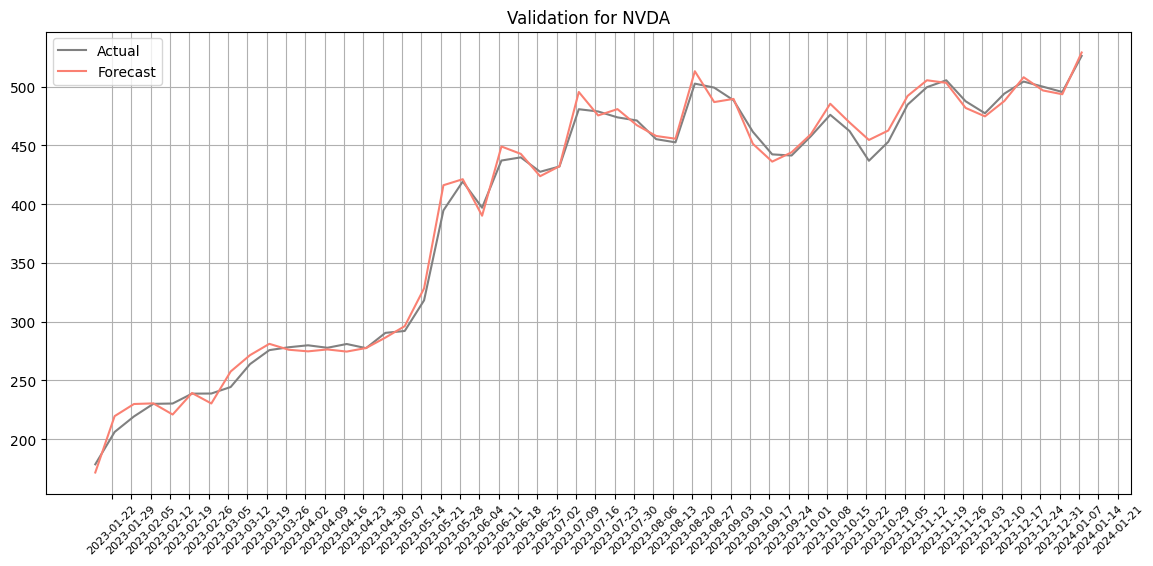

In [27]:
forecaster.forecast_validation(period='5y', order=(1, 1, 1))

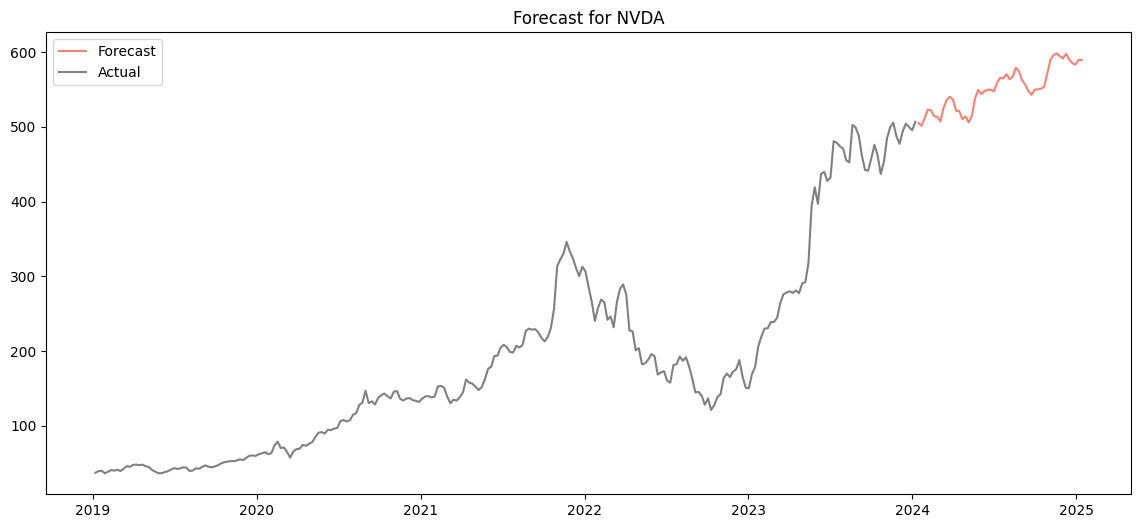

In [71]:
forecaster.plot_forecast(forecast_only=False)

In [83]:
forecaster.find_max_profit()
forecaster.NVDA['max_profit']

,current,profit %,action
2024-01-22/2024-01-28,508.796674,,buy
2024-11-18/2024-11-24,607.527060,19.4,sell


In [152]:
forecaster.find_best_trades()
forecaster.NVDA['best_trades']

,current,profit %,action,hold period
2024-01-22/2024-01-28,512.16641,,buy,
2024-02-05/2024-02-11,533.5711,4.18,sell,2
2024-03-04/2024-03-10,518.353856,,buy,
2024-03-25/2024-03-31,551.171044,6.33,sell,3
2024-04-22/2024-04-28,521.831175,,buy,
2024-04-29/2024-05-05,525.648638,0.73,sell,1
2024-05-06/2024-05-12,517.629484,,buy,
2024-05-27/2024-06-02,562.206839,8.61,sell,3
2024-06-03/2024-06-09,556.390391,,buy,
2024-06-17/2024-06-23,562.661284,1.13,sell,2
